# Uber Data Analysis using PySpark

## Data

The data used in this notebook was sourced from Kaggle. The files I used, contain data on over 2.6 million Uber pickups in New York City from July to September 2014.

The files can be downloaded here: https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city

(For this project I am only using the data for July, August and September)



## Objectives


1. Find out which hour of the day is the busiest for Uber in NYC

2. Find out which day of the week is the busiest for Uber in NYC

3. Visualize the data from all csv files in a heatmap

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import *

import initspark


Setting up the schema and importing all csv file in the 'uber' folder


In [2]:
spark = SparkSession.builder.appName('TaxiData').getOrCreate()

schema = StructType([
    StructField("date", StringType()),
    StructField("lat", DoubleType()),
    StructField("lon", DoubleType()),
    StructField("base", StringType())
])

csv = spark.read.option("header", "true").csv("./data/uber/*.csv", schema = schema).cache()

In [4]:
csv.show(10)

+----------------+-------+--------+------+
|            date|    lat|     lon|  base|
+----------------+-------+--------+------+
|8/1/2014 0:03:00|40.7366|-73.9906|B02512|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|
|8/1/2014 0:12:00|40.7387|-73.9856|B02512|
|8/1/2014 0:12:00|40.7323|-74.0077|B02512|
|8/1/2014 0:13:00|40.7349|-74.0033|B02512|
|8/1/2014 0:15:00|40.7279|-73.9542|B02512|
|8/1/2014 0:17:00| 40.721|-73.9937|B02512|
|8/1/2014 0:19:00|40.7195| -74.006|B02512|
|8/1/2014 0:20:00|40.7448|-73.9799|B02512|
+----------------+-------+--------+------+
only showing top 10 rows



The data contains:

Date/Time : The date and time of the Uber pickup

Lat : The latitude of the Uber pickup

Lon : The longitude of the Uber pickup

Base : The TLC base company code affiliated with the Uber pickup

It has > 2.6 million entries

In [6]:
csv.count()

2653532

In [7]:
csv.printSchema()

root
 |-- date: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)



The 'date' column is not in timestamp format, but string format => needs to be converted

So  next we define a function that will change all values in our 'date' column

In [8]:
from datetime import datetime
import pyspark.sql.functions as F

f = F.udf(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S"), TimestampType())

In [9]:
csv.withColumn("date", f(csv.date)).printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)



The 'date' column has successfully been converted to timestamp

'withColumn' returns a new DataFrame by adding a column or replacing the existing column that has the same name

In [39]:
data = csv.withColumn("date", f(csv.date))

In [13]:
data.show(10)

+--------------------+-------+--------+------+
|                date|    lat|     lon|  base|
+--------------------+-------+--------+------+
|2014-08-01 00:03:...|40.7366|-73.9906|B02512|
|2014-08-01 00:09:...| 40.726|-73.9918|B02512|
|2014-08-01 00:12:...|40.7209|-74.0507|B02512|
|2014-08-01 00:12:...|40.7387|-73.9856|B02512|
|2014-08-01 00:12:...|40.7323|-74.0077|B02512|
|2014-08-01 00:13:...|40.7349|-74.0033|B02512|
|2014-08-01 00:15:...|40.7279|-73.9542|B02512|
|2014-08-01 00:17:...| 40.721|-73.9937|B02512|
|2014-08-01 00:19:...|40.7195| -74.006|B02512|
|2014-08-01 00:20:...|40.7448|-73.9799|B02512|
+--------------------+-------+--------+------+
only showing top 10 rows



Now we can start analyzing the data

# 1. Which hour of the day is the busiest for Uber in NYC?

We want to group our 'date' column by hour, count all entries for each hour of the day and order by hour 

In [15]:
dataPerHour = data\
    .groupBy(F.date_format(data.date, "H"))\
    .count()\
    .orderBy("date_format(date, H)")\
    .cache()

dataPerHour.show()


+--------------------+------+
|date_format(date, H)| count|
+--------------------+------+
|                   0| 63537|
|                   1| 42105|
|                  10| 96898|
|                  11|100719|
|                  12|102199|
|                  13|116638|
|                  14|134644|
|                  15|155469|
|                  16|174108|
|                  17|188755|
|                  18|187698|
|                  19|175000|
|                   2| 29369|
|                  20|167521|
|                  21|161488|
|                  22|140043|
|                  23| 99523|
|                   3| 30364|
|                   4| 34489|
|                   5| 51719|
+--------------------+------+
only showing top 20 rows



'date_format(date, H)' column is in string format, so orderBy() didn't work as we wanted it to

By using cast(IntergerType()) we can transform the entries into integers and then orderBy hour to get the desired result

In [17]:
dataPerHourFetched = dataPerHour\
    .withColumn("hour", dataPerHour["date_format(date, H)"].cast(IntegerType()))\
    .orderBy("hour")\
    .collect()

print(dataPerHourFetched)

[Row(date_format(date, H)='0', count=63537, hour=0), Row(date_format(date, H)='1', count=42105, hour=1), Row(date_format(date, H)='2', count=29369, hour=2), Row(date_format(date, H)='3', count=30364, hour=3), Row(date_format(date, H)='4', count=34489, hour=4), Row(date_format(date, H)='5', count=51719, hour=5), Row(date_format(date, H)='6', count=81670, hour=6), Row(date_format(date, H)='7', count=109923, hour=7), Row(date_format(date, H)='8', count=112430, hour=8), Row(date_format(date, H)='9', count=97223, hour=9), Row(date_format(date, H)='10', count=96898, hour=10), Row(date_format(date, H)='11', count=100719, hour=11), Row(date_format(date, H)='12', count=102199, hour=12), Row(date_format(date, H)='13', count=116638, hour=13), Row(date_format(date, H)='14', count=134644, hour=14), Row(date_format(date, H)='15', count=155469, hour=15), Row(date_format(date, H)='16', count=174108, hour=16), Row(date_format(date, H)='17', count=188755, hour=17), Row(date_format(date, H)='18', count=1

Now we can use this to make a graph using matplotlib by storing the data in x and y

In [18]:
x = []
y = []
for row in dataPerHourFetched:
    x.append(row["date_format(date, H)"])
    y.append(row["count"])

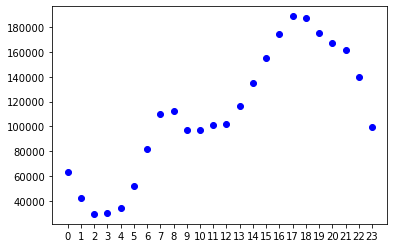

In [19]:

plt.plot(x, y, 'bo')
plt.show()

=> We can see that the busiest time for Uber in NYC is at around 5pm

# 2. Which day of the week is the busiest for Uber in NYC?


In [20]:
dataPerDayOfWeek = data\
    .groupBy(F.date_format(data.date, "u"))\
    .count()\
    .orderBy("date_format(date, u)")\
    .cache()

We group our data using 'u' which gives us a number for each day of the week (1 = Monday...7 = Sunday). As this again returns a string, we have to transform the entries into integers 

In [21]:
dataPerDayOfWeek\
    .withColumn("dayOfWeek", dataPerDayOfWeek["date_format(date, u)"].cast(IntegerType()))\
    .orderBy("dayOfWeek")\
    .show()

+--------------------+------+---------+
|date_format(date, u)| count|dayOfWeek|
+--------------------+------+---------+
|                   1|322110|        1|
|                   2|407808|        2|
|                   3|398346|        3|
|                   4|425832|        4|
|                   5|411789|        5|
|                   6|384542|        6|
|                   7|303105|        7|
+--------------------+------+---------+



In [22]:
rows = dataPerDayOfWeek\
    .withColumn("dayOfWeek", dataPerDayOfWeek["date_format(date, u)"].cast(IntegerType()))\
    .orderBy("dayOfWeek")\
    .collect()

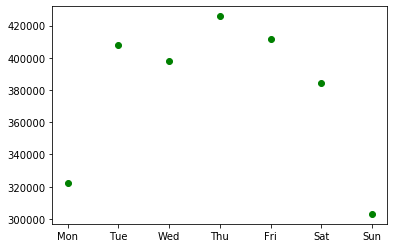

In [27]:
x1 = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
y1 = []
for row in rows:
    y1.append(row['count'])
    
plt.plot(x1, y1, 'go')
plt.show()

=> We can see that the highest demand for Ubers in NYC is on Thursdays

# 3. Visualize the data from all csv files in a heatmap

We want to get an image that shows all the demand for Ubers in NYC. So we pick two locations, one will determine the upper left corner of our image, the other the bottom right corner

In [41]:
#Upper left corner:    40.90366, -74.10665   [0][0]
#Bottom right corner:  40.66704, -73.83396

In [29]:
dataFiltered = data\
    .where(data.lat > 40.66704)\
    .where(data.lat < 40.90366)\
    .where(data.lon < -73.83396)\
    .where(data.lon > -74.10665)\
    .cache()

We only include data that is between 40.66704 and 40.90366 lat, and between -73.83396 and -74.10665 lon, this only excludes a relatively small amount of our total data

In [34]:
print(data.count())
print(dataFiltered.count())

2653532
2466020


In [55]:
dataFiltered\
    .select(
        F.round(((dataFiltered.lat - 40.66704) / (40.90366 - 40.66704)) * size),
        F.round(((dataFiltered.lon + 73.83396) / (-74.10665 + 73.83396)) * size)
    )\
    .withColumnRenamed(
        "round((((lat - 40.66704) / 0.23662000000000205) * " + str(size) + "), 0)", 
        "lat"
    )\
    .withColumnRenamed(
        "round((((lon + 73.83396) / -0.2726899999999972) * " + str(size) + "), 0)", 
        "lon"
    )\
    .groupBy("lat", "lon")\
    .count()\
    .orderBy("lat","lon")\
    .show()

+---+-----+-----+
|lat|  lon|count|
+---+-----+-----+
|0.0|  2.0|    2|
|0.0| 29.0|    1|
|0.0|175.0|    1|
|0.0|223.0|    1|
|0.0|240.0|    1|
|0.0|286.0|    1|
|0.0|347.0|    1|
|0.0|356.0|    1|
|0.0|357.0|    3|
|0.0|359.0|    1|
|0.0|360.0|    2|
|0.0|366.0|    1|
|0.0|420.0|    2|
|0.0|422.0|    3|
|0.0|423.0|    3|
|0.0|424.0|    1|
|0.0|425.0|    3|
|0.0|426.0|    1|
|0.0|428.0|    2|
|0.0|459.0|    2|
+---+-----+-----+
only showing top 20 rows



We define the size of our image to be 1000 and transform the location of the Uber pickup to the location of the pixel in our image, rename the resulting columns, group by lat and lon and count all entries for the respective location, which now becomes the brightness of our pixel

In [33]:
size = 1000
dataForImage = dataFiltered\
    .select(
        F.round(((dataFiltered.lat - 40.66704) / (40.90366 - 40.66704)) * size),
        F.round(((dataFiltered.lon + 73.83396) / (-74.10665 + 73.83396)) * size)
    )\
    .withColumnRenamed(
        "round((((lat - 40.66704) / 0.23662000000000205) * " + str(size) + "), 0)", 
        "lat"
    )\
    .withColumnRenamed(
        "round((((lon + 73.83396) / -0.2726899999999972) * " + str(size) + "), 0)", 
        "lon"
    )\
    .groupBy("lat", "lon")\
    .count()\
    .collect()

We create an 'empty' image:

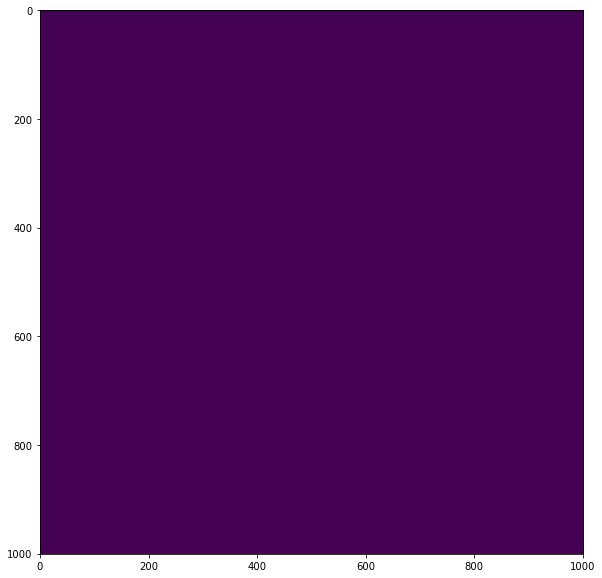

In [59]:
import math
img = []
for i in range(0, size + 1):
    imgRow = []
    for j in range(0, size + 1):
        imgRow.append(0)
    img.append(imgRow)
    
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

Now we iterate over every row from our dataForImage and insert the data that we have in the respective pixel that it describes as brightness. As there are some areas that have a lot of counts, therefore would appear very bright and

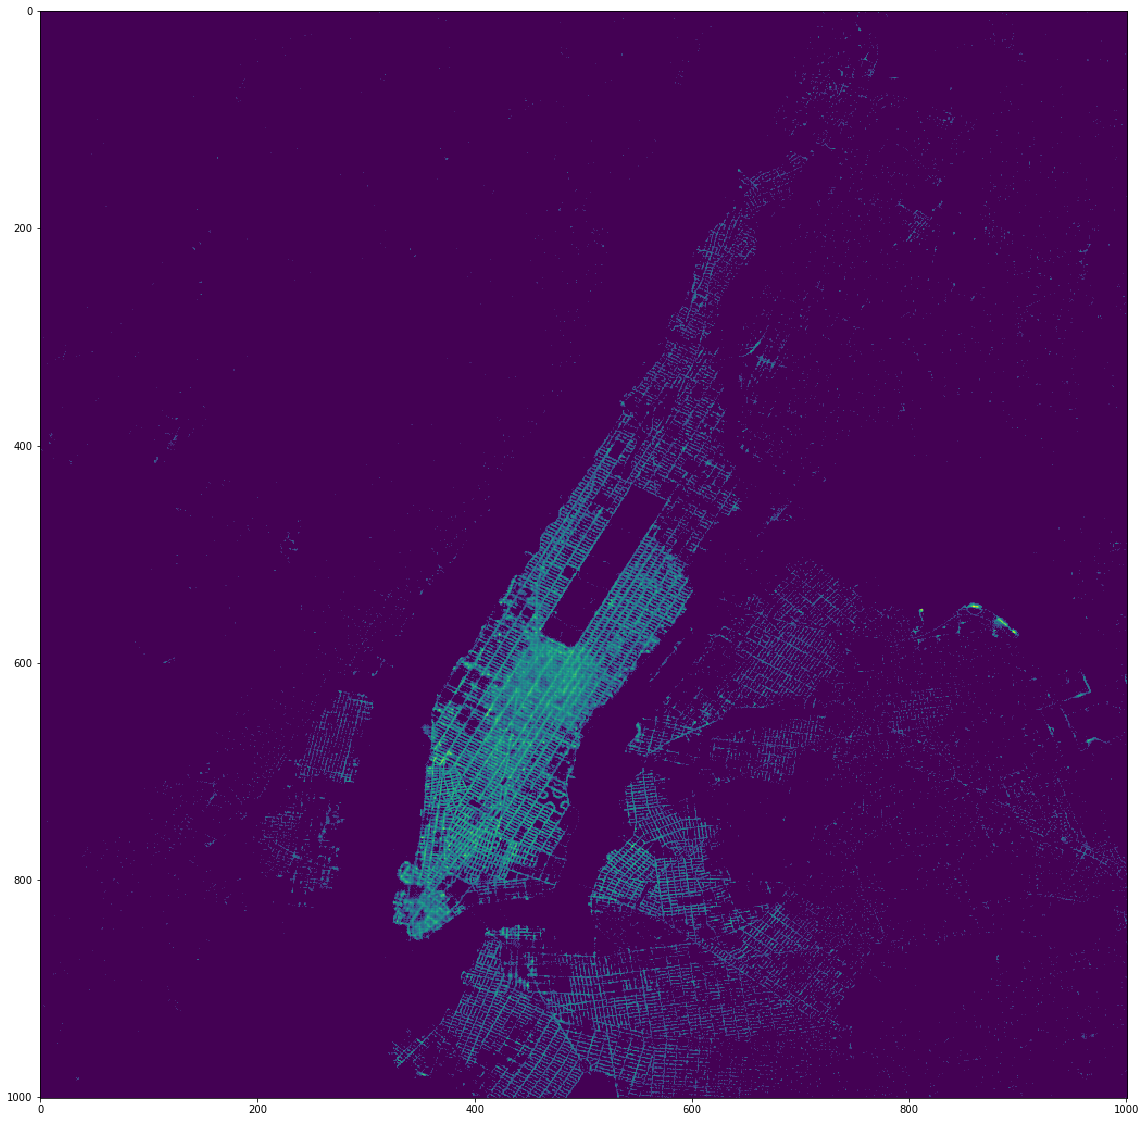

In [58]:
for row in dataForImage:
    img[size - int(row.lat)][size - int(row.lon)] = math.log(row["count"])

plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()

=> Now we have visualized the data for all Uber pickups in the area between July and September, showing the busiest areas which gives us a great image with all the streets cleary visible and a bright spot on the right side showing pick ups from LaGuardia Ariport